# Part 3: Parton Level Fisher Information via Machine Learning

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 6. Obtaining the Fisher Information using Machine Learning

Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

To not forget anything later, let us globaly define the number of events in the MG sample

In [2]:
inputfile = 'data/madminer_example_shuffled.h5'
nsamples = 100000

### 6a) Make (unweighted) training and test samples with augmented data

The next step is handled by the `madminer.sampling` class `SampleAugmenter`. From all the data we have in the MadMiner file now, it extracts unweighted samples including the augmented data, that is needed as training and evaluation data for the machine learning algorithms.

In [3]:
sa = SampleAugmenter(inputfile, debug=False)

18:15  
18:15  ------------------------------------------------------------
18:15  |                                                          |
18:15  |  MadMiner v0.1.0                                         |
18:15  |                                                          |
18:15  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:15  |                                                          |
18:15  ------------------------------------------------------------
18:15  
18:15  Loading data from data/madminer_example_shuffled.h5
18:15  Found 2 parameters:
18:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:15  Found 6 benchmarks:
18:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
18:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
18:15     morphing_basis_vector_2: CWL2 = -4.21e+01, CPWL2 = -2.54e+01
18:15     morphing_basis_vector_3: CWL2 = 28.77, CPWL2 = -4

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. For the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`. 

Here we are mostly interested in evaluating the Fisher Info at the SM benchmark. We will create two sets of samples, one for training and one for testing. In particular, for training we create `n_estimator` sets of samples. This will allow us later to better investigate the uncertainty of the estimates Fisher Information. 

In [4]:
#Define n_estimator
n_estimators = 5

#augment train sample
for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_ensemble/',
        filename='train{}'.format(i)
    )

#augment test sample
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_ensemble/',
    filename='test'
)

18:15  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
18:15  Effective number of samples: 50000.00000004142
18:15  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
18:15  Effective number of samples: 50000.00000004142
18:15  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
18:15  Effective number of samples: 50000.00000004142
18:15  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
18:15  Effective number of samples: 50000.00000004142
18:15  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
18:15  Effective number of samples: 50000.00000004142
18:15  Extracting evaluation sample. Sampling according to (u'benchmark', u'sm')
18:15  Effecti

### 6b)  Train a neural network to estimate the score

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class to get a single estimator. Additionally, instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [5]:
ensemble = EnsembleForge(estimators=n_estimators)

In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files

In [6]:
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)

ensemble.save('models/samples_ensemble')

18:15  Training 5 estimators in ensemble
18:15  Training estimator 1 / 5 in ensemble
18:15  Starting training
18:15    Method:                 sally
18:15    Training data: x at data/samples_ensemble/x_train0.npy
18:15                   t_xz (theta0) at  data/samples_ensemble/t_xz_train0.npy
18:15    Features:               all
18:15    Method:                 sally
18:15    Hidden layers:          (100, 100)
18:15    Activation function:    tanh
18:15    Batch size:             128
18:15    Trainer:                amsgrad
18:15    Epochs:                 50
18:15    Learning rate:          0.001 initially, decaying to 0.0001
18:15    Validation split:       None
18:15    Early stopping:         True
18:15    Scale inputs:           True
18:15    Shuffle labels          False
18:15    Regularization:         None
18:15  Loading training data
18:15  Found 50000 samples with 2 parameters and 24 observables
18:15  Rescaling inputs
18:15  Creating model for method sally
18:15  Training mod

### 6c)  Train a neural network with subset of observables

We can also train the EnsembleForge with just a subset of observables. This is done with the option `features`. In the following example we drop the unobservable degrees of freedom of the neutrino

In [7]:
ensemble_met = EnsembleForge(estimators=n_estimators)
ensemble_met.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
    features=(0,1,2, 3,4,5, 6,8, 9,11, 12,13,14, 15,17, 18,19,20, 23)
)
ensemble_met.save('models/samples_metonly')

20:25  Training 5 estimators in ensemble
20:25  Training estimator 1 / 5 in ensemble
20:25  Starting training
20:25    Method:                 sally
20:25    Training data: x at data/samples_ensemble/x_train0.npy
20:25                   t_xz (theta0) at  data/samples_ensemble/t_xz_train0.npy
20:25    Features:               (0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23)
20:25    Method:                 sally
20:25    Hidden layers:          (100, 100)
20:25    Activation function:    tanh
20:25    Batch size:             128
20:25    Trainer:                amsgrad
20:25    Epochs:                 50
20:25    Learning rate:          0.001 initially, decaying to 0.0001
20:25    Validation split:       None
20:25    Early stopping:         True
20:25    Scale inputs:           True
20:25    Shuffle labels          False
20:25    Regularization:         None
20:25  Loading training data
20:25  Found 50000 samples with 2 parameters and 24 observables
20:25  Rescaling i

20:29    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
20:29    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
20:29  Finished training


### 6d) Evaluate Fisher Information

Any evaluation of this ensemble will provide us with mean and variance of the predictions. Let's try that for the Fisher information: **Fix Lumi Bug**

In [8]:
fisher = FisherInformation(inputfile, debug=False)

fi_ml_mean, fi_ml_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_metonly_mean, fi_metonly_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_metonly',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_truth_mean, fi_truth_covariance = fisher.calculate_fisher_information_full_truth(
    theta=[0.,0.],
    luminosity=300*1000./nsamples
)

20:29  Loading data from data/madminer_example_shuffled.h5
20:29  Found 2 parameters:
20:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
20:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
20:29  Found 6 benchmarks:
20:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
20:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
20:29     morphing_basis_vector_2: CWL2 = -4.21e+01, CPWL2 = -2.54e+01
20:29     morphing_basis_vector_3: CWL2 = 28.77, CPWL2 = -4.77e+01
20:29     morphing_basis_vector_4: CWL2 = -5.80e+00, CPWL2 = 47.46
20:29     morphing_basis_vector_5: CWL2 = -3.60e+01, CPWL2 = 13.10
20:29  Found 24 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva, m_la
20:29  Found 100000 events
20:29  Found morphing setup with 6 components
20:29  Evaluating rate Fisher information
20:29  Found ensemble with 5 estimators and expectati

The covariance can be propagated to the Fisher distance contour plot easily. Note that this also includes uncertainty bands corresponding to the uncertainty of the Machine Learning. This uncertainty corresponds to the standard devisation of the different ensemble constituents. 

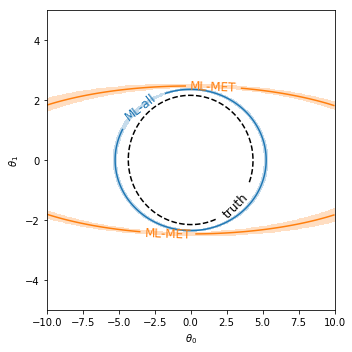

In [9]:
_ = plot_fisher_information_contours_2d(
    [fi_ml_mean, fi_metonly_mean, fi_truth_mean ],
    [fi_ml_covariance, fi_metonly_covariance, fi_truth_covariance],
    colors=[u'C0',u'C1',"black"],
    linestyles=["solid","solid","dashed"],
    inline_labels=["ML-all","ML-MET","truth"],
    xrange=(-10,10),
    yrange=(-5,5)
)

In [10]:
fi_metonly_mean

array([[4.56170669e-03, 1.56056314e-04],
       [1.56056314e-04, 1.64619438e-01]])

## 7. Cross-Check: Validating score estimation

Let us now validate that the Machine Learning works. The central object consideres here is the score, so we will compare the truth level score with the estimated scores.  

### 7a) Run the Data Augmentation and Machine Learning part

First, we once again augment the dataand machine learning part again.

In [16]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5', debug=False)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scores/',
    test_split=None,
    filename='train'
)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scores/',
    test_split=None,
    filename='test',
    switch_train_test_events=True
)

16:57  Loading data from data/madminer_example_shuffled.h5
16:57  Found 2 parameters:
16:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:57  Found 6 benchmarks:
16:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:57     morphing_basis_vector_2: CWL2 = -4.21e+01, CPWL2 = -2.54e+01
16:57     morphing_basis_vector_3: CWL2 = 28.77, CPWL2 = -4.77e+01
16:57     morphing_basis_vector_4: CWL2 = -5.80e+00, CPWL2 = 47.46
16:57     morphing_basis_vector_5: CWL2 = -3.60e+01, CPWL2 = 13.10
16:57  Found 24 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva, m_la
16:57  Found 100000 events
16:57  Found morphing setup with 6 components
16:57  Extracting training sample for local score regression. Sampling and score evaluation acc

Next, we use the perform the ML part, but with only one sample. We therefore use `MLForge` instead of `EnsembleForge`

In [ ]:
forge = MLForge()
forge.train(
    method='sally',
    x_filename='./data/samples_scores/x_train.npy',
    t_xz0_filename='./data/samples_scores/t_xz_train.npy',
    #features=(0,1,2, 3,4,5, 6,8, 9,11, 12,13,14, 15,17, 18,19,20, 23)
)
forge.save('models/samples_scores')

16:57  Starting training
16:57    Method:                 sally
16:57    Training data: x at ./data/samples_scores/x_train.npy
16:57                   t_xz (theta0) at  ./data/samples_scores/t_xz_train.npy
16:57    Features:               all
16:57    Method:                 sally
16:57    Hidden layers:          (100, 100)
16:57    Activation function:    tanh
16:57    Batch size:             128
16:57    Trainer:                amsgrad
16:57    Epochs:                 50
16:57    Learning rate:          0.001 initially, decaying to 0.0001
16:57    Validation split:       None
16:57    Early stopping:         True
16:57    Scale inputs:           True
16:57    Shuffle labels          False
16:57    Regularization:         None
16:57  Loading training data
16:57  Found 50000 samples with 2 parameters and 24 observables
16:57  Rescaling inputs
16:57  Creating model for method sally
16:57  Training model
16:57    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
16:57    Epoch 10: train los

### 7b) Obtain scores

We can now obtain the scores. The truth scores have been stored during the augmentation step, and can simply be loaded. The ML scores can be evaluated.  

In [ ]:
#True score
t_truth_train=np.load('./data/samples_scores/t_xz_train.npy')
t_truth_test=np.load('./data/samples_scores/t_xz_test.npy')

#ML score 
t_ml_train=forge.evaluate('./data/samples_scores/x_train.npy')
t_ml_test=forge.evaluate('./data/samples_scores/x_test.npy')

Let us now visualize the scores. The figure shows the 
- top:  score distribution
- center: the score correlation as 2D histogram
- bottom: the score correlation as scatter plot
Here we just present the 1st and 2nd component of the score. 

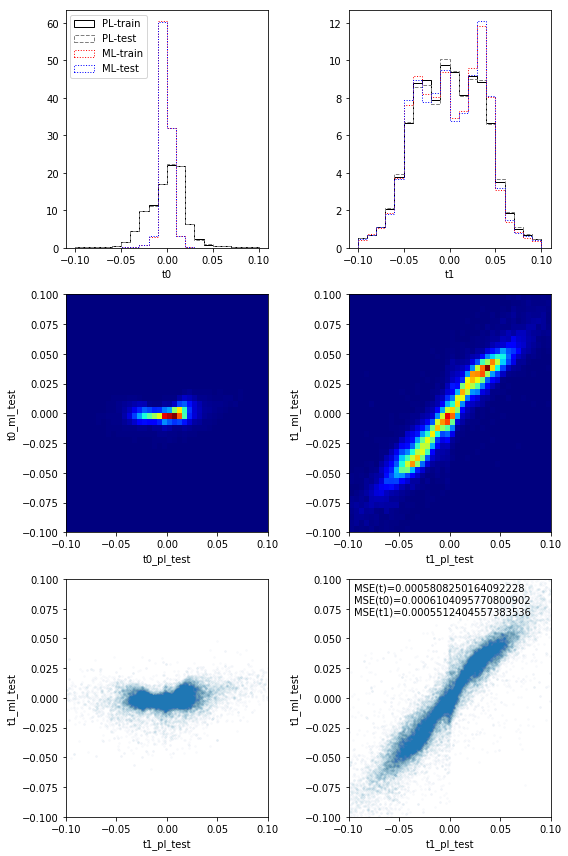

In [14]:
#######
#Figure
myrange=(-.1,.1)
myrangex=[-.1,.1]
f, ((ax11, ax12),(ax21, ax22),(ax31, ax32)) = plt.subplots(3, 2)
f.set_size_inches(8,12)

#######
#Distributions
mynbins=20

#t0
ax11.set_xlabel('t0')
ax11.hist(t_truth_train[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Black', linestyle='solid', label='PL-train'
        )
ax11.hist(t_truth_test[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Gray', linestyle='dashed', label='PL-test'
        )
ax11.hist(t_ml_train[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Red', linestyle='dotted',label='ML-train'
        )
ax11.hist(t_ml_test[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Blue', linestyle='dotted',label='ML-test'
        )
ax11.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)

#t1
ax12.set_xlabel('t1')
ax12.hist(t_truth_train[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Black', linestyle='solid'
        )
ax12.hist(t_truth_test[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Gray', linestyle='dashed', 
        )
ax12.hist(t_ml_train[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Red', linestyle='dotted'
        )
ax12.hist(t_ml_test[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Blue', linestyle='dotted'
        )

#######
#Density
ax21.hist2d(t_truth_test[:,0], t_ml_test[:,0], bins=(40, 40), range=(myrange,myrange) ,cmap='jet')
ax21.set_xlabel('t0_pl_test')
ax21.set_ylabel('t0_ml_test')

ax22.hist2d(t_truth_test[:,1], t_ml_test[:,1], bins=(40, 40), range=(myrange,myrange) ,cmap='jet')
ax22.set_xlabel('t1_pl_test')
ax22.set_ylabel('t1_ml_test')

#######
#MSE
mse_0 = mean_squared_error(t_truth_test[:,0],t_ml_test[:,0])
mse_1 = mean_squared_error(t_truth_test[:,1],t_ml_test[:,1])
mse_x = mean_squared_error(t_truth_test,t_ml_test)

#######
#Scatter
ax31.scatter(t_truth_test[:,0], t_ml_test[:,0],s=3,alpha=0.02)
ax31.set_xlabel('t1_pl_test')
ax31.set_ylabel('t1_ml_test')
ax31.set_xlim(myrangex)
ax31.set_ylim(myrangex)

ax32.scatter(t_truth_test[:,1], t_ml_test[:,1],s=3,alpha=0.02)
ax32.set_xlabel('t1_pl_test')
ax32.set_ylabel('t1_ml_test')
ax32.set_xlim(myrangex)
ax32.set_ylim(myrangex)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.95*(myrange[1]-myrange[0]), 'MSE(t)='+str(mse_x), fontsize=10)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.90*(myrange[1]-myrange[0]), 'MSE(t0)='+str(mse_0), fontsize=10)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.85*(myrange[1]-myrange[0]), 'MSE(t1)='+str(mse_1), fontsize=10)

#######
#Plot
plt.tight_layout()
plt.show()

### 7c) Kinematic distribution of scores 

We can also look at kinematic distribution of scores

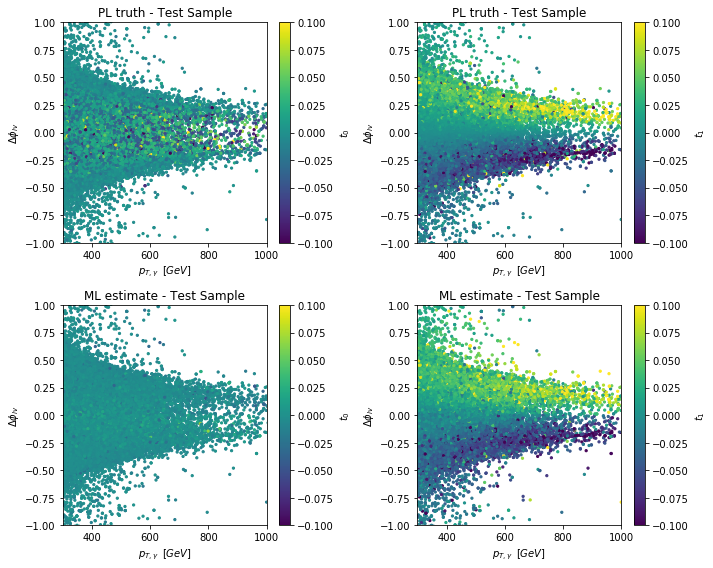

In [15]:
#Which pbservables to show

x_test=np.load('./data/samples_scores/x_test.npy')[:,14]
y_test=np.load('./data/samples_scores/x_test.npy')[:,18]
x_name='$p_{T,\gamma}\;\;[GeV]$'
y_name='$\Delta\phi_{lv}$'
x_range=[300,1000]
y_range=[-1,1]
v_range=[-.1,.1]
t_pl_test=np.load('./data/samples_scores/t_xz_test.npy')
t_ml_test=forge.evaluate('./data/samples_scores/x_test.npy')

#######
#Figure
marker_size=5
f, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2, 2)
f.set_size_inches(10,8)

# t0 PL test
im11=ax11.scatter(x_test, y_test, marker_size, c=t_pl_test[:,0],vmin=v_range[0],vmax=v_range[1])
ax11.set_title("PL truth - Test Sample")
ax11.set_xlabel(x_name)
ax11.set_ylabel(y_name)
ax11.set_xlim(x_range)
ax11.set_ylim(y_range)
cb11=f.colorbar(im11, ax=ax11)
cb11.set_label("$t_0$")

# t1 PL test
im12=ax12.scatter(x_test, y_test, marker_size, c=t_pl_test[:,1],vmin=v_range[0],vmax=v_range[1])
ax12.set_title("PL truth - Test Sample")
ax12.set_xlabel(x_name)
ax12.set_ylabel(y_name)
ax12.set_xlim(x_range)
ax12.set_ylim(y_range)
cb12=f.colorbar(im12, ax=ax12)
cb12.set_label("$t_1$")

# t0 ML test
im21=ax21.scatter(x_test, y_test, marker_size, c=t_ml_test[:,0],vmin=v_range[0],vmax=v_range[1])
ax21.set_title("ML estimate - Test Sample")
ax21.set_xlabel(x_name)
ax21.set_ylabel(y_name)
ax21.set_xlim(x_range)
ax21.set_ylim(y_range)
cb21=f.colorbar(im21, ax=ax21)
cb21.set_label("$t_0$")

# t1 ML test
im22=ax22.scatter(x_test, y_test, marker_size, c=t_ml_test[:,1],vmin=v_range[0],vmax=v_range[1])
ax22.set_title("ML estimate - Test Sample")
ax22.set_xlabel(x_name)
ax22.set_ylabel(y_name)
ax22.set_xlim(x_range)
ax22.set_ylim(y_range)
cb22=f.colorbar(im22, ax=ax22)
cb22.set_label("$t_1$")

#######
#Plot
plt.tight_layout()
plt.show()